<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L30-GraphConvolutionalNetworks-NodeRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node Regression with Graph Convolutional Networks
## Predicting web traffic with node regression

The dataset we will use is the Wikipedia Network (GNU General Public License v3.0), introduced by [Rozemberckzi et al. in 2019](https://arxiv.org/abs/1909.13021). It is composed of three page-page networks: chameleons (2,277 nodes and 31,421 edges), crocodiles (11,631 nodes and 170,918 edges), and squirrels (5,201 nodes and 198,493 edges). In these datasets, nodes represent articles and edges are mutual links between them. Node features reflect the presence of particular words in the articles. Finally, the goal is to predict the log average monthly traffic of December 2018.

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [20]:
import torch
torch.manual_seed(1)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

we will apply a GCN to predict this traffic on the chameleon dataset. We import the Wikipedia Network and download the chameleon dataset. We apply the `transform` function, `RandomNodeSplit()`, to randomly create an evaluation mask and a test mask

In [2]:
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T

dataset = WikipediaNetwork(root=".", name="chameleon", transform = T.RandomNodeSplit(num_val=200, num_test=500))
data = dataset[0]

Processing...
Done!


In [3]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of unique features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: WikipediaNetwork()
-------------------
Number of graphs: 1
Number of nodes: 2277
Number of unique features: 2325
Number of classes: 5

Graph:
------
Edges are directed: True
Graph has isolated nodes: False
Graph has loops: True


There is a problem with our dataset: the output says that we have five classes. However, we want to perform node regression, not classification. So what happened?

In fact, these five classes are bins of the continuous values we want to predict. Unfortunately, these labels are not the ones we want: we have to change them manually. First, let’s download the wikipedia.zip file from the following page: https://snap.stanford.edu/data/wikipedia-article-networks.html.

In [4]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

After unzipping the file, we import pandas and use it to load the targets:

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('wikipedia/chameleon/musae_chameleon_target.csv')
df.head()

,id,target
0,0,171
1,1,8089
2,2,8568
3,3,47178
4,4,3634


Apply a log function to the target values using np.log10() because the goal is to predict the log average monthly traffic

In [8]:
values = np.log10(df['target'])

Redefine data.y as a tensor of the continuous values from the previous step. Note that these values are not normalized in this example, which is a good practice that is usually implemented. We will not perform it here for ease of exposition:

In [9]:
data.y = torch.tensor(values)
data.y

tensor([2.2330, 3.9079, 3.9329,  ..., 1.9956, 4.3598, 2.4409],
       dtype=torch.float64)

Once again, it is a good idea to visualize the node degrees as we did for the two previous datasets. We use the exact same code to produce the following figure:

<BarContainer object of 63 artists>

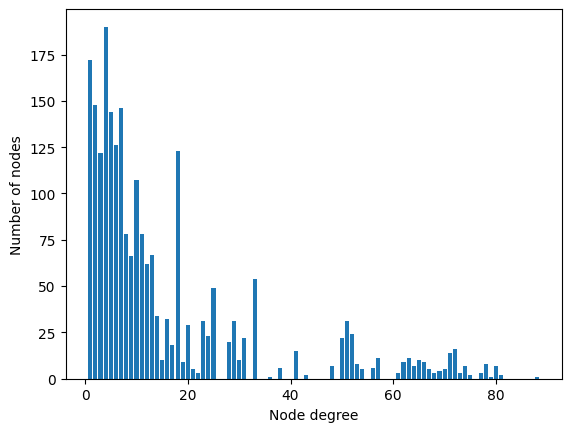

In [21]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

This distribution, most nodes have one or a few neighbors, but some of them act as “hubs” and can connect more than 80 nodes.

In the case of node regression, the distribution of node degrees is not the only type of distribution we should check: the distribution of our target values is also essential. Indeed, non-normal distribution (such as node degrees) tends to be harder to predict. We can use the Seaborn library to plot the target values and compare them to a normal distribution provided by `scipy.stats.norm()`

<ipython-input-22-98934f87a9a2>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  fig = sns.distplot(df['target'], fit=norm)


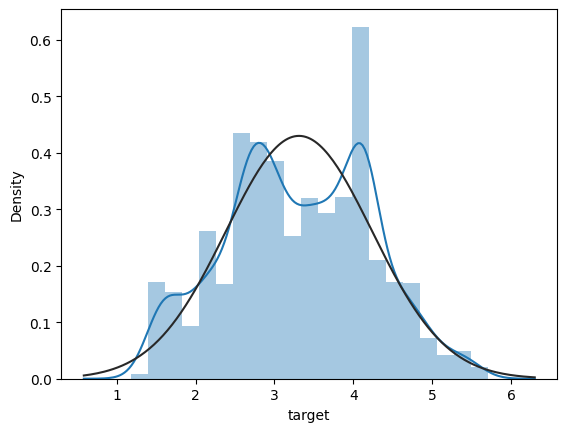

In [22]:
import seaborn as sns
from scipy.stats import norm

df['target'] = values
fig = sns.distplot(df['target'], fit=norm)

We define the GCN class and the `__init__()` function. This time, we have three `GCNConv` layers with a decreasing number of neurons. The idea behind this encoder architecture is to force the model to select the most relevant features to predict the target values. We also added a linear layer to output a prediction that is not limited to a number between 0 or -1 and 1.

In [23]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4)
        self.gcn2 = GCNConv(dim_h*4, dim_h*2)
        self.gcn3 = GCNConv(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)

The `forward()` method includes the new `GCNConv` and `nn.Linear` layers. There is no need for a log `softmax` function here since we’re not predicting a class

In [31]:
def forward(self, x, edge_index):
    h = self.gcn1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn3(h, edge_index)
    h = torch.relu(h)
    h = self.linear(h)
    return h

# Add forward to GCN
GCN.forward = forward

The main change in the `fit()` method is the `F.mse_loss()` function, which replaces the cross-entropy loss used in classification tasks. The `Mean Squared Error (MSE)` will be our main metric. It corresponds to the average of the squares of the errors and can be defined as follows:

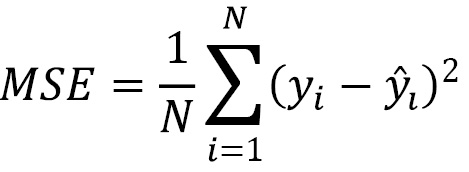

In [32]:
def fit(self, data, epochs):
    optimizer = torch.optim.Adam(self.parameters(),
                                  lr=0.02,
                                  weight_decay=5e-4)

    self.train()
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask])
            print(f"Epoch {epoch:>3} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

# Add fit to GCN
GCN.fit = fit

The MSE is also included in the `test()` method

In [33]:
@torch.no_grad()
def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    return F.mse_loss(out.squeeze()[data.test_mask], data.y[data.test_mask].float())

# Add test to GCN
GCN.test = test

Instantiate the model with 128 hidden dimensions and only 1 output dimension (the target value). It is trained on 200 epochs.

In [34]:
# Create the Vanilla GNN model
gcn = GCN(dataset.num_features, 128, 1)
print(gcn)

# Train
gcn.fit(data, epochs=200)

GCN(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0 | Train Loss: 11.45423 | Val Loss: 11.22350
Epoch  20 | Train Loss: 11.41529 | Val Loss: 11.21260
Epoch  40 | Train Loss: 8.81631 | Val Loss: 8.39077
Epoch  60 | Train Loss: 1.65645 | Val Loss: 1.57090
Epoch  80 | Train Loss: 0.74586 | Val Loss: 0.86194
Epoch 100 | Train Loss: 0.53863 | Val Loss: 0.73836
Epoch 120 | Train Loss: 0.44510 | Val Loss: 0.75915
Epoch 140 | Train Loss: 0.47484 | Val Loss: 0.87467
Epoch 160 | Train Loss: 0.40077 | Val Loss: 0.70497
Epoch 180 | Train Loss: 0.38003 | Val Loss: 0.75935
Epoch 200 | Train Loss: 0.34841 | Val Loss: 0.74027


Test it to obtain the MSE on the test set

In [35]:
# Test
loss = gcn.test(data)
print(f'\nGCN test loss: {loss:.5f}\n')


GCN test loss: 0.72402



This MSE loss is not the most interpretable metric by itself. We can get more meaningful results using the two following metrics:

- The RMSE, which measures the average magnitude of the error:

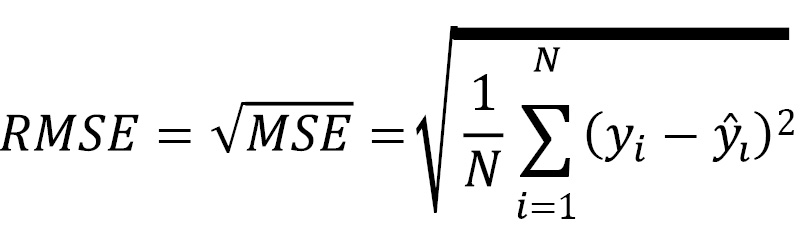

- The Mean Absolute Error (MAE), which gives the mean absolute difference between the predicted and real values:

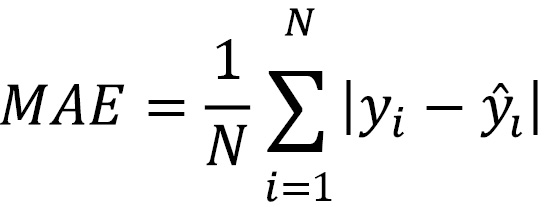

We can directly import the MSE and the MAE from the scikit-learn library

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

We convert the PyTorch tensors for the predictions into the NumPy arrays given by the model using `.detach().numpy()`

In [37]:
out = gcn(data.x, data.edge_index)
y_pred = out.squeeze()[data.test_mask].detach().numpy()
mse = mean_squared_error(data.y[data.test_mask], y_pred)
mae = mean_absolute_error(data.y[data.test_mask], y_pred)

We compute the MSE and the MAE with their dedicated function. The RMSE is calculated as the square root of MSE using `np.sqrt()`:

In [38]:
print('=' * 43)
print(f'MSE = {mse:.4f} | RMSE = {np.sqrt(mse):.4f} | MAE = {mae:.4f}')
print('=' * 43)

MSE = 0.7240 | RMSE = 0.8509 | MAE = 0.6518


These metrics are useful for comparing different models, but it can be difficult to interpret the MSE and the RMSE.

The best tool to visualize the results of our model is a scatter plot, where the horizontal axis represents our predictions and the vertical axis represents the real values. Seaborn has a dedicated function (`regplot()`) for this type of visualization

[Text(0.5, 0, 'Ground truth'), Text(0, 0.5, 'Predicted values')]

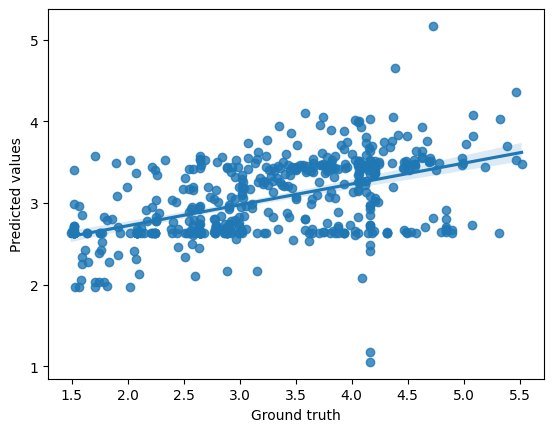

In [39]:
fig = sns.regplot(x=data.y[data.test_mask].numpy(), y=y_pred)
fig.set(xlabel='Ground truth', ylabel='Predicted values')

We don’t have a baseline to work with in this example, but this is a decent prediction with few outliers. It would work in a lot of applications, despite a minimalist dataset. If we wanted to improve these results, we could tune the hyperparameters and do more error analysis to understand where the outliers come from.